In [1]:
#!pip install -U xgboost

In [2]:
#!pip install -U optuna
# for third party library support
#!pip install -U optuna-integration

In [3]:
import os
import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback

C:\Users\laure\anaconda3\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
N_JOBS = 8  # number of parallel threads

# repeated K-folds
N_SPLITS = 10
N_REPEATS = 1

In [5]:
df = pd.read_csv( 'D:\GitHub\MSc-Project\SWaT DataSWaT Scaled.csv')

In [6]:
df.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,FIT504,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603
0,2015-12-22 16:30:00,0.0,0.005294,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
1,2015-12-22 16:30:01,0.0,0.005407,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
2,2015-12-22 16:30:02,0.0,0.005520,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
3,2015-12-22 16:30:03,0.0,0.005801,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0
4,2015-12-22 16:30:04,0.0,0.005576,0.5,0.0,0.0,0.012291,0.075099,0.002009,0.0,...,0.0,0.0,0.0,0.000814,0.0,0.001217,0.000147,0.0,0.0,0.0


In [7]:
df = df.drop(columns=['Timestamp'])

In [8]:
# check for columns only containing 0
empty_cols = []
for col in df.columns:
    if (df[col] == 0).all():
        empty_cols.append(col)


In [9]:
df= df.drop(columns= empty_cols)

In [10]:
random_state = 44

In [11]:
train_df, temp = train_test_split(df, test_size= 0.4, random_state= random_state)

In [12]:
test_df, eval_df = train_test_split(temp, test_size= 0.5, random_state= random_state)

In [13]:
train_size= train_df.shape
test_size= test_df.shape
eval_size= eval_df.shape

In [14]:
print(f'Data sizes are Train:{train_size}, Test:{test_size}, Eval:{eval_size}')

Data sizes are Train:(297000, 40), Test:(99000, 40), Eval:(99000, 40)


In [15]:
all_cols= train_df.columns

In [16]:
dependent_col= 'LIT101'
independent_cols= [x for x in all_cols if x != dependent_col ]


[]

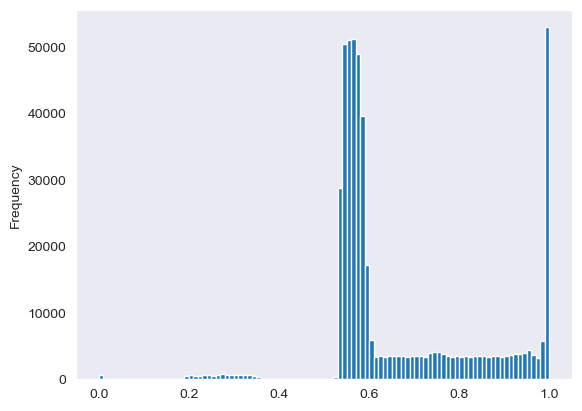

In [17]:
ax = df.LIT101.plot.hist(bins= 100)
ax.grid()
ax.set()

In [18]:
X_train = train_df[independent_cols]
X_test = test_df[independent_cols]
y_train = train_df[dependent_col]

In [19]:
def evaluate_model_rkf(model, X_df, y_df, n_splits=5, n_repeats=2, random_state= random_state):
    X_values = X_df.values
    y_values = y_df.values
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A = y_values[train_index]
        model.fit(
            X_A, y_A,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [20]:
model = RandomForestRegressor(random_state= random_state, n_jobs=N_JOBS)
evaluate_model_rkf(
    model, X_train, y_train, n_splits= N_SPLITS, n_repeats= N_REPEATS, random_state= random_state
)

0.0024377713658742233

In [21]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [22]:
len(importances)

39

In [23]:
type(indices)

numpy.ndarray

In [24]:
features = X_train.columns
for x,y in enumerate(indices):
    print(f'Importance:{x+1}, Name:{features[y]}')



Importance:1, Name:FIT201
Importance:2, Name:LIT401
Importance:3, Name:FIT101
Importance:4, Name:LIT301
Importance:5, Name:MV101
Importance:6, Name:AIT501
Importance:7, Name:AIT504
Importance:8, Name:AIT503
Importance:9, Name:AIT202
Importance:10, Name:DPIT301
Importance:11, Name:AIT201
Importance:12, Name:AIT402
Importance:13, Name:PIT502
Importance:14, Name:FIT502
Importance:15, Name:AIT502
Importance:16, Name:P501
Importance:17, Name:AIT203
Importance:18, Name:FIT301
Importance:19, Name:PIT501
Importance:20, Name:FIT504
Importance:21, Name:UV401
Importance:22, Name:MV304
Importance:23, Name:FIT401
Importance:24, Name:PIT503
Importance:25, Name:FIT501
Importance:26, Name:P101
Importance:27, Name:MV201
Importance:28, Name:FIT503
Importance:29, Name:P203
Importance:30, Name:FIT601
Importance:31, Name:P302
Importance:32, Name:P402
Importance:33, Name:MV302
Importance:34, Name:AIT401
Importance:35, Name:MV303
Importance:36, Name:P205
Importance:37, Name:MV301
Importance:38, Name:P602
Imp

NameError: name 'X_df' is not defined

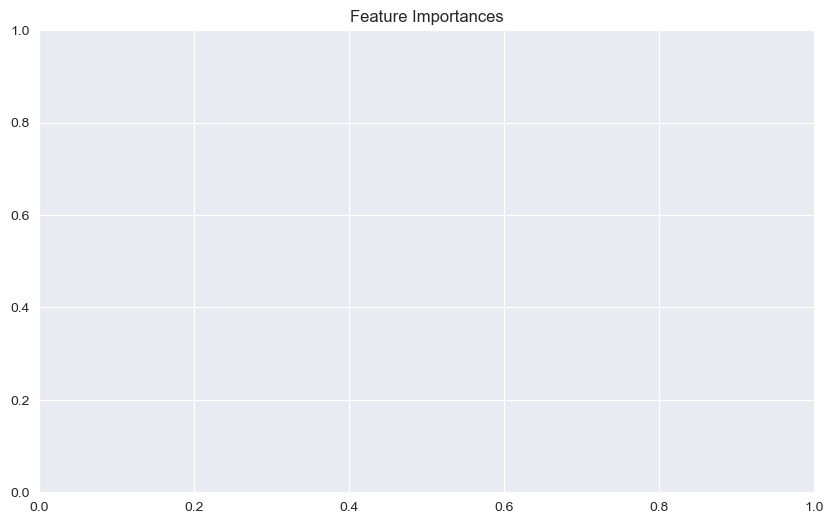

In [26]:


# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_df.shape[1]), importances[indices], align='center')
plt.xticks(range(X_df.shape[1]), X_df.columns[indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()